# シンプルなseq2seq
最小限のSeq2Seqを構築し、時系列の変換を行います。  
今回は、Seq2Seqを使って、sin関数の曲線をcos関数の曲線に”翻訳”します。  
Seq2Seqの構築方法について、基礎から学んでいきましょう。

## 訓練用データの作成
訓練用のデータを作成します。  
今回は、sin関数の値をencoderへの入力、cos関数の値をdecoderへの入力、及び正解とします。  
decoderへの入力は、正解から一つ後の時刻にずらします。  
これにより、ある時刻におけるdecoderの出力が、次の時刻における入力に近づくように学習を行うことができます。  
このような、ある時刻における正解が次の時刻の入力となる手法を**教師強制**といいます。

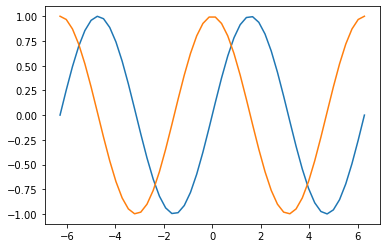

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

axis_x = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_data = np.sin(axis_x)  # sin関数
cos_data = np.cos(axis_x)  # cos関数

plt.plot(axis_x, sin_data)
plt.plot(axis_x, cos_data)
plt.show()

n_rnn = 10  # 時系列の数
n_sample = len(axis_x)-n_rnn  # サンプル数
x_encoder = np.zeros((n_sample, n_rnn))  # encoderの入力
x_decoder = np.zeros((n_sample, n_rnn))  # decoderの入力
t_decoder = np.zeros((n_sample, n_rnn))  # decoderの正解

for i in range(0, n_sample):
    x_encoder[i] = sin_data[i:i+n_rnn]
    x_decoder[i, 1:] = cos_data[i:i+n_rnn-1]  # 一つ後の時刻にずらす。最初の値は0のまま。
    t_decoder[i] = cos_data[i:i+n_rnn]  # 正解は、cos関数の値をそのまま入れる

x_encoder = x_encoder.reshape(n_sample, n_rnn, 1)  # （サンプル数、時系列の数、入力層のニューロン数）
x_decoder = x_decoder.reshape(n_sample, n_rnn, 1)
t_decoder = t_decoder.reshape(n_sample, n_rnn, 1)

## Seq2Seqの構築
Kerasを使ってSeq2Seqを構築します。  
今回は、Sequentialクラスではなく、**Modelクラス**を使います。  
Modelクラスを使えば、複数の経路の入力を持つニューラルネットワークを構築可能で、状態を渡すことでRNN同士を接続することもできます。  
今回は、Seq2SeqのRNN部分にはLSTMを使います。

In [2]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input

n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = n_in  # 出力層のニューロン数

encoder_input = Input(shape=(n_rnn, n_in))  # encoderの入力層
encoder_lstm = LSTM(n_mid, return_state=True)  # return_stateをTrueにすることで、出力とともに状態（htとメモリセル）が得られる
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)  # 出力、状態（ht）、状態（メモリセル）
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = Input(shape=(n_rnn, n_in))  # decoderの入力層
decoder_lstm = LSTM(n_mid, return_sequences=True, return_state=True)  # return_sequenceがTrueで、全ての時系列の出力が得られる
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_state)  # encoderの状態を初期状態にする
decoder_dense = Dense(n_out, activation='linear')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)  # 入力と出力を設定し、Modelクラスでモデルを作成
model.compile(loss="mean_squared_error", optimizer="adam")
print(model.summary())

2021-07-13 04:59:39.897825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20), (Non

## 学習
構築したSeq2Seqのモデルを使って、学習を行います。

In [3]:
history = model.fit([x_encoder, x_decoder], t_decoder,
                     batch_size=8,
                     epochs=30)

2021-07-13 04:59:56.527969: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/30
5/5 [==============================] - 284s 21ms/step - loss: 0.4470
Epoch 2/30
5/5 [==============================] - 0s 58ms/step - loss: 0.4069
Epoch 3/30
5/5 [==============================] - 0s 25ms/step - loss: 0.3718
Epoch 4/30
5/5 [==============================] - 0s 107ms/step - loss: 0.3368
Epoch 5/30
5/5 [==============================] - 0s 13ms/step - loss: 0.3115
Epoch 6/30
5/5 [==============================] - 0s 80ms/step - loss: 0.3009
Epoch 7/30
5/5 [==============================] - 0s 49ms/step - loss: 0.2764
Epoch 8/30
5/5 [==============================] - 0s 89ms/step - loss: 0.2702
Epoch 9/30
5/5 [==============================] - 0s 13ms/step - loss: 0.2300
Epoch 10/30
5/5 [==============================] - 0s 60ms/step - loss: 0.2185
Epoch 11/30
5/5 [==============================] - 0s 61ms/s

## 学習の推移
誤差の推移を確認します。

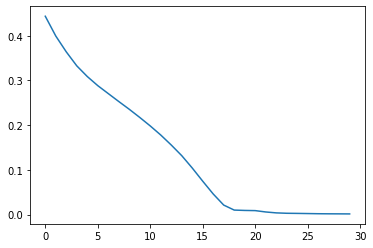

In [4]:
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

## 予測用モデルの構築
学習済みのオブジェクトから、encoder、decoderのモデルを個別に構築します。    
encoderは入力を受け取って状態を返し、decoderは入力と状態を受け取って出力と状態を返すようにします。

In [5]:
# encoderのモデルを構築
encoder_model = Model(encoder_input, encoder_state)  # 間にあるLSTM層は学習済み

# decoderのモデルを構築
decoder_input = Input(shape=(1, n_in))

decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in_c = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h, decoder_state_in_c]

decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input,  # 既存の学習済みLSTM層を使用
                                                                 initial_state=decoder_state_in)  
decoder_state = [decoder_state_h, decoder_state_c]

decoder_output = decoder_dense(decoder_output)  # 既存の学習済み全結合層を使用
decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_state) # リストを+で結合

## 翻訳用の関数
入力を”翻訳”し、出力に変換するための関数を設定します。  
decoderでは、各時刻ごとに予測を行い、出力と状態を次の時刻に渡します。

In [6]:
def translate(input_data):
    state_value = encoder_model.predict(input_data)  # encoderから状態を取得
    y_decoder = np.zeros((1, 1, 1))  # 出力の値
    translated = []  # 翻訳結果
    
    for i in range(0, n_rnn):  # 各時刻ごとに予測を行う
        y, h, c = decoder_model.predict([y_decoder] + state_value)  # 前の時刻の出力と状態を渡す
        y = y[0][0][0]
        translated.append(y)
        y_decoder[0][0][0] = y  # 次の時刻に渡す値
        state_value = [h, c]  # 次の時刻に渡す状態

    return translated

## 翻訳を実行
sin関数の曲線を、cos関数の曲線に翻訳します。

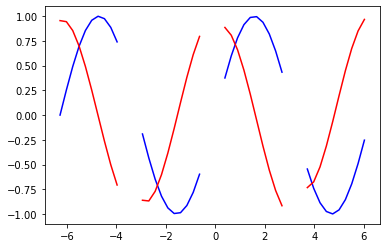

In [7]:
demo_idices = [0, 13, 26, 39]  # デモに使うデータのインデックス
for i in demo_idices:
    x_demo = x_encoder[i:i+1]  # 入力を一部取り出す
    y_demo = translate(x_demo)  # 翻訳する
    
    plt.plot(axis_x[i:i+n_rnn], x_demo.reshape(-1), color="b")  # 翻訳前（青）
    plt.plot(axis_x[i:i+n_rnn], y_demo, color="r")  # 翻訳後（赤）
    
plt.show()    

sinカーブがcosカーブに”翻訳”されていますね。  
以上のように、Seq2Seqでは時系列データの変換を行うことができます。